# Import necessities

In [21]:
import matplotlib.pyplot as plt
import torch
from torch import nn
from tqdm.auto import tqdm
from sklearn.metrics import (ConfusionMatrixDisplay, classification_report, confusion_matrix)
from torchvision import transforms
from torchvision.io import read_image
import torchvision
import numpy as np
import os, random
import cv2
from torchvision import models
from PIL import Image
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
from torchinfo import summary

# Configuration File

In [20]:
# Hyper parameters etc.
class CFG:
    n_epochs = 100
    learning_rate = 1e-3
    batch_size = 1024
    seed = 42
    
    # Model parameters
    num_class = None


In [6]:
# Set random seeds for reproducibility
def seed_everything(seed = 42):
  random.seed(seed)
  os.environ['PYTHONHASHSEED'] = str(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.backends.cudnn.deterministic = True

seed_everything(CFG.seed)

# Download the dataset

In [7]:
train_data = torchvision.datasets.FashionMNIST(root = 'data', train = True, transform = transforms.ToTensor(), download = True)
test_data = torchvision.datasets.FashionMNIST(root = 'data', train = False, transform = transforms.ToTensor(), download = True)

train_data, test_data

100%|████████████████████████████████████████████████████████████████| 26421880/26421880 [00:01<00:00, 25418567.79it/s]


Extracting data\FashionMNIST\raw\train-images-idx3-ubyte.gz to data\FashionMNIST\raw



100%|████████████████████████████████████████████████████████████████████████████████████| 29515/29515 [00:00<?, ?it/s]


Extracting data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to data\FashionMNIST\raw



100%|█████████████████████████████████████████████████████████████████| 4422102/4422102 [00:00<00:00, 233368229.03it/s]


Extracting data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to data\FashionMNIST\raw



100%|██████████████████████████████████████████████████████████████████████████████████████| 5148/5148 [00:00<?, ?it/s]

Extracting data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to data\FashionMNIST\raw



(Dataset FashionMNIST
     Number of datapoints: 60000
     Root location: data
     Split: Train
     StandardTransform
 Transform: ToTensor(),
 Dataset FashionMNIST
     Number of datapoints: 10000
     Root location: data
     Split: Test
     StandardTransform
 Transform: ToTensor())

# Splitting the dataset

The Fashion MNIST dataset in torchvision does not have an explicit validation set. So, I am taking a portion out of the train data as the validation data. Since, there are 10k images in the test set, I will take out 10k images from the train set for validation.

In [8]:
val_fraction = round(1/6, 3)
train_fraction = 1 - val_fraction

train_data, val_data = torch.utils.data.random_split(train_data, [train_fraction, val_fraction])

train_data, val_data, test_data, len(train_data), len(val_data), len(test_data)

(<torch.utils.data.dataset.Subset at 0x1329c84ca90>,
 Dataset FashionMNIST
     Number of datapoints: 10000
     Root location: data
     Split: Test
     StandardTransform
 Transform: ToTensor(),
 49980,
 10020,
 10000)

# Transform datasets to dataloader

In [9]:
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size = CFG.batch_size, shuffle = True)
val_dataloader = torch.utils.data.DataLoader(val_data, batch_size = CFG.batch_size, shuffle = False)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size = CFG.batch_size, shuffle = False)

In [10]:
CFG.num_class = len(test_data.classes)
CFG.num_class

10

# Create the model

In [11]:
class CNNmodel(nn.Module):
  def __init__(self, num_class: int = CFG.num_class):
    super().__init__()
    self.conv_block = nn.Sequential(
        nn.Conv2d(in_channels = 1, out_channels = 3, kernel_size = 3, stride = 1, padding = 1), # output_shape = 3x28x28
        nn.ReLU(),
        nn.Conv2d(in_channels = 3, out_channels = 5, kernel_size = 3, stride = 1, padding = 1), # output_shape = 5x28x28
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2, stride = 2), # output_shape = 5x14x14
        nn.Conv2d(in_channels = 5, out_channels = 5, kernel_size = 3, stride = 1, padding = 1), # output_shape = 5x14x14
        nn.ReLU(),
        nn.Conv2d(in_channels = 5, out_channels = 3, kernel_size = 3, stride = 1, padding = 1), # output_shape = 3x14x14
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2, stride = 2), # output_shape = 3x7x7
        # nn.AdaptiveAvgPool2d(1), # Global Average pooling layer # output_shape = 3x1x1

        # Fully connected layer block
        nn.Flatten(),
        nn.Linear(in_features = 3*7*7, out_features = 147),
        nn.BatchNorm1d(num_features = 147),
        nn.Sigmoid(),
        nn.Linear(in_features = 147, out_features = num_class)
    )
    self._initialize_weights_()

  def _initialize_weights_(self):
      for layer in self.children():
        if isinstance(layer, nn.Linear):
          nn.init.xavier_uniform_(layer.weight)
          nn.init.zeros_(layer.bias)
        elif isinstance(layer, nn.Conv2d):
          nn.init.xavier_uniform_(layer.weight)
          nn.init.zeros_(layer.bias)

  def forward(self, x: torch.Tensor):
    return self.conv_block(x)

In [12]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model_1 = CNNmodel().to(device)

In [13]:
# Let's see the inner layers of the model
summary(model = model_1,
        input_size = (1, 1, 28, 28),
        col_names = ["input_size", "output_size", "num_params", "trainable"],
        col_width = 20,
        row_settings = ["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
CNNmodel (CNNmodel)                      [1, 1, 28, 28]       [1, 10]              --                   True
├─Sequential (conv_block)                [1, 1, 28, 28]       [1, 10]              --                   True
│    └─Conv2d (0)                        [1, 1, 28, 28]       [1, 3, 28, 28]       30                   True
│    └─ReLU (1)                          [1, 3, 28, 28]       [1, 3, 28, 28]       --                   --
│    └─Conv2d (2)                        [1, 3, 28, 28]       [1, 5, 28, 28]       140                  True
│    └─ReLU (3)                          [1, 5, 28, 28]       [1, 5, 28, 28]       --                   --
│    └─MaxPool2d (4)                     [1, 5, 28, 28]       [1, 5, 14, 14]       --                   --
│    └─Conv2d (5)                        [1, 5, 14, 14]       [1, 5, 14, 14]       230                  True
│    └─ReLU (6)     

# Define Loss function and Optimizer

In [14]:
optimizer = torch.optim.Adam(params = model_1.parameters(), lr = CFG.learning_rate)
loss_fn = nn.CrossEntropyLoss()
device = "cuda" if torch.cuda.is_available() else "cpu"
# scheduler = torch.optim.lr_scheduler.StepLR(
#     optimizer,
#     step_size=CFG.step_size,
#     gamma=CFG.gamma
# )

In [15]:
def validate(
    model,
    val_loader: torch.utils.data.DataLoader,
    criterion: torch.nn.Module,
    device: torch.device
) -> tuple:
    """
    Validate the model

    :param model: The model to validate
    :type model: torch.nn.Module
    :param val_loader: The validation loader
    :type val_loader: torch.utils.data.DataLoader
    :param criterion: The loss function
    :type criterion: torch.nn.Module
    :param device: The device to use
    :type device: torch.device

    :return: The loss, accuracy and predictions
    :rtype: tuple
    """
    model.eval()
    val_loss = 0.0
    correct = 0
    y_pred = []
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            y_pred.extend(predicted.cpu().numpy())

    val_loss /= len(val_loader)
    accuracy = correct / len(y_pred)

    return val_loss, accuracy, y_pred

# Evaluate Function

In [29]:
def validate(
    model,
    val_loader: torch.utils.data.DataLoader,
    criterion: torch.nn.Module,
    device: torch.device
) -> tuple:
    """
    Validate the model

    :param model: The model to validate
    :type model: torch.nn.Module
    :param val_loader: The validation loader
    :type val_loader: torch.utils.data.DataLoader
    :param criterion: The loss function
    :type criterion: torch.nn.Module
    :param device: The device to use
    :type device: torch.device

    :return: The loss, accuracy and predictions
    :rtype: tuple
    """
    model.eval()
    val_loss = 0.0
    correct = 0
    y_pred = []
    with torch.inference_mode():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            y_pred.extend(predicted.cpu().numpy())

    val_loss /= len(val_loader)
    accuracy = correct / len(y_pred)

    return val_loss, accuracy, y_pred

# Train function

In [23]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device = device):
  train_loss = 0
  model.to(device)
  for batch, (X, y) in enumerate(data_loader):
    # Send data to GPU
    X, y = X.to(device), y.to(device)

    # 1. Forward pass
    y_pred = model(X)

    # 2. Calculate loss
    loss = loss_fn(y_pred, y)
    train_loss += loss

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

  # Calculate loss and accuracy per epoch and print out what's happening
  train_loss /= len(data_loader)
  print(f"Train loss: {train_loss:.5f}")
  return train_loss

def val_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              device: torch.device = device):
  test_loss = 0
  model.to(device)
  model.eval() # put model in eval mode
  # Turn on inference context manager
  with torch.inference_mode():
    for X, y in data_loader:
      # Send data to GPU
      X, y = X.to(device), y.to(device)

      # 1. Forward pass
      test_pred = model(X)

      # 2. Calculate loss
      test_loss += loss_fn(test_pred, y)

    # Adjust metrics and print out
    test_loss /= len(data_loader)

    print(f"Val loss: {test_loss:.5f}\n")
  return test_loss

# Train the model

In [24]:
train_loss_log = []
val_loss_log = []

for epoch in tqdm(range(CFG.n_epochs)):
  print(f"Epoch: {epoch+1}\n---------")
  train_loss = train_step(data_loader=train_dataloader,
                          model=model_1,
                          loss_fn=loss_fn,
                          optimizer=optimizer)

  train_loss_log.append(train_loss.item())

  val_loss = val_step(data_loader=val_dataloader,
                      model=model_1,
                      loss_fn=loss_fn)


  if len(val_loss_log) != 0:
    if val_loss < min(val_loss_log):
      torch.save(obj = model_1.state_dict(),
                 f = "checkpoint.pth")
      # save the model
  val_loss_log.append(val_loss.item())

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 1
---------
Train loss: 1.64162
Val loss: 1.77656

Epoch: 2
---------
Train loss: 0.99662
Val loss: 0.71153

Epoch: 3
---------
Train loss: 0.61821
Val loss: 0.57356

Epoch: 4
---------
Train loss: 0.53015
Val loss: 0.50840

Epoch: 5
---------
Train loss: 0.48383
Val loss: 0.47035

Epoch: 6
---------
Train loss: 0.45257
Val loss: 0.45690

Epoch: 7
---------
Train loss: 0.42864
Val loss: 0.42942

Epoch: 8
---------
Train loss: 0.40654
Val loss: 0.41555

Epoch: 9
---------
Train loss: 0.39593
Val loss: 0.40718

Epoch: 10
---------
Train loss: 0.38478
Val loss: 0.39795

Epoch: 11
---------
Train loss: 0.37264
Val loss: 0.38247

Epoch: 12
---------
Train loss: 0.36154
Val loss: 0.37890

Epoch: 13
---------
Train loss: 0.35563
Val loss: 0.37159

Epoch: 14
---------
Train loss: 0.34799
Val loss: 0.36957

Epoch: 15
---------
Train loss: 0.34236
Val loss: 0.36546

Epoch: 16
---------
Train loss: 0.33910
Val loss: 0.35921

Epoch: 17
---------
Train loss: 0.33462
Val loss: 0.35445

Epoch:

#### **Plot the learning curve**

Plot the training loss and validation loss using `matplotlib`, keep both the training loss and validation loss in the same plot.


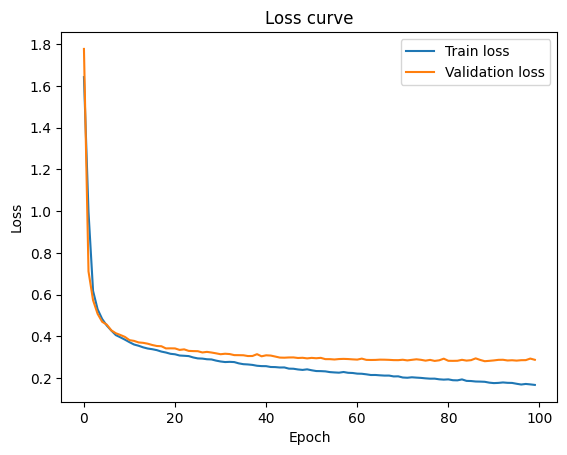

In [25]:
plt.plot(train_loss_log, label="Train loss")
plt.plot(val_loss_log, label="Validation loss")
plt.title("Loss curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

#### **Load the model from the checkpoint**

Use `torch.load` to load the model from the checkpoint and use the `model.load_state_dict` method to load the model weights.


In [27]:
# model_1.load_state_dict(torch.load("checkpoint.pth")["model"])
model_1 = CNNmodel().to(device) # Initialize model again
model_1.load_state_dict(torch.load(f = "checkpoint.pth"))

C:\Users\Ahnaf\AppData\Local\Temp\ipykernel_23956\1769497309.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_1.load_state_dict(torch.load(f = "checkpoint.pth"))


<All keys matched successfully>

# **Evaluate model performance**

Now, we have trained the model. Call the `validate` function to validate the model and calculate the loss and predicted labels on the testing data.

1. Use scikit-learn's `classification_report` function to evaluate the performance of the model. The `classification_report` function takes two inputs, `test_labels` and `predicted_labels`, and returns a report of the precision, recall, and F1-score of the model.
2. Use the `confusion_matrix` function to get the confusion matrix of the model. It also takes two inputs, `test_labels` and `predicted_labels`, and returns the confusion matrix of the model. Use `ConfusionMatrixDisplay` to display the confusion matrix.


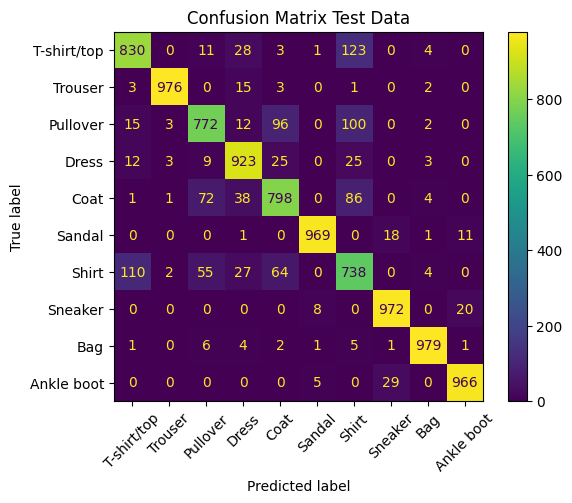




              precision    recall  f1-score   support

 T-shirt/top       0.85      0.83      0.84      1000
     Trouser       0.99      0.98      0.98      1000
    Pullover       0.83      0.77      0.80      1000
       Dress       0.88      0.92      0.90      1000
        Coat       0.81      0.80      0.80      1000
      Sandal       0.98      0.97      0.98      1000
       Shirt       0.68      0.74      0.71      1000
     Sneaker       0.95      0.97      0.96      1000
         Bag       0.98      0.98      0.98      1000
  Ankle boot       0.97      0.97      0.97      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



In [30]:
_, _, y_pred = validate(model_1, test_dataloader, loss_fn, device)
y_test = [labels for _, labels in test_dataloader]
y_test = torch.cat(y_test).numpy()

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(
    y_test, y_pred), display_labels=test_data.classes)
disp = disp.plot(xticks_rotation=45)
plt.title('Confusion Matrix Test Data')
plt.show()

print('\n\n')
print(classification_report(y_test, y_pred, target_names=test_data.classes))